# Spaceship titanic
Door Juan Camilo Huizinga Mora

> In deze competitie is jouw taak om te voorspellen of een passagier naar een alternatieve dimensie werd getransporteerd tijdens de botsing van de Spaceship Titanic met de ruimtetijdsanomalie. Om je te helpen bij deze voorspellingen, krijg je een reeks persoonlijke gegevens die zijn hersteld uit het beschadigde computersysteem van het schip. (bron: kaggle)

train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
* **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
* **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* **Destination** - The planet the passenger will be debarking to.
* **Age** - The age of the passenger.
* **VIP** - Whether the passenger has paid for special VIP service during the voyage.
* **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.**
* **Name** - The first and last names of the passenger.
* **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


*Note: Ik heb naar aanleiding van ons gesprek de notebook een beetje veranderd, daarom ziet hij er anders uit dan tijdens het gesprekje.*

In [42]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

url = 'train.csv'
df = pd.read_csv(url)
df.columns = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported']

df.head()
#Even verkennen

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Dataopschonen

* Eerst ga ik kijken naar de null values en deze oplossen.


In [43]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

* Dit valt best mee we hebben in totaal 8700 regels, dus we gaan dit simpel oplossen. Ik verander de null value met de vorige value in de kolom te pakken.

In [44]:
df.fillna(method='pad', inplace=True)

In [45]:
df.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

* Alle null values zijn nu opgelost.
* Voordat ik alle values verander in numerieke waardes. Wil ik eerst de cabin feature opsplitsen, want dit zou relevant kunnen zijn of ze transported zijn. Het is nu deck/num/side.

In [46]:
df[['Deck', 'Number', 'Side']] = df['Cabin'].str.split('/', expand=True)
df = df.drop('Cabin', axis=1)
df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


* We droppen de feature naam, omdat dit waarschijnlijk weinig relevantie heeft en het is lastig om het te vertalen in numerieke waardes.

In [47]:
df.drop('Name', axis=1, inplace=True)

In [48]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S


* Ik ga eerst kijken naar welke unique values er zijn om te veranderen naar numerieke waardes.

In [49]:
df['Deck'].unique()

array(['B', 'F', 'A', 'G', 'E', 'D', 'C', 'T'], dtype=object)

In [50]:
df['Side'].unique()

array(['P', 'S'], dtype=object)

In [51]:
df['Destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e'], dtype=object)

In [52]:
df['HomePlanet'].unique()

array(['Europa', 'Earth', 'Mars'], dtype=object)

* We gaan nu alle values veranderen in numerieke waardes. Dit zodat we makkelijk de correlaties kunnen berekenen. En de voorspel algoritmes hebben dit ook nodig om transported te voorspellen.

In [53]:
df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0})
df['VIP'] = df['VIP'].map({True: 1, False: 0})
df['Transported'] = df['Transported'].map({True: 1, False: 0})
df['Destination'] = df['Destination'].map({'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2})
df['Deck'] = df['Deck'].map({'B': 1, 'F': 5, 'A': 0, 'G': 6, 'E': 4, 'D': 3, 'C': 2, 'T': 7})
df['Side'] = df['Side'].map({'P': 0, 'S': 1})
df['HomePlanet'] = df['HomePlanet'].map({'Europa': 0, 'Earth': 1, 'Mars': 2})

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   int64  
 2   CryoSleep     8693 non-null   int64  
 3   Destination   8693 non-null   int64  
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   int64  
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  VRDeck        8693 non-null   float64
 11  Transported   8693 non-null   int64  
 12  Deck          8693 non-null   int64  
 13  Number        8693 non-null   object 
 14  Side          8693 non-null   int64  
dtypes: float64(6), int64(7), object(2)
memory usage: 1018.8+ KB


* Nu nog even Number naar int veranderen

In [55]:
df['Number'] = pd.to_numeric(df['Number'])

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   int64  
 2   CryoSleep     8693 non-null   int64  
 3   Destination   8693 non-null   int64  
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   int64  
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  VRDeck        8693 non-null   float64
 11  Transported   8693 non-null   int64  
 12  Deck          8693 non-null   int64  
 13  Number        8693 non-null   int64  
 14  Side          8693 non-null   int64  
dtypes: float64(6), int64(8), object(1)
memory usage: 1018.8+ KB


* Nu is alles numeriek en kunnen we de correlatie berekenen.

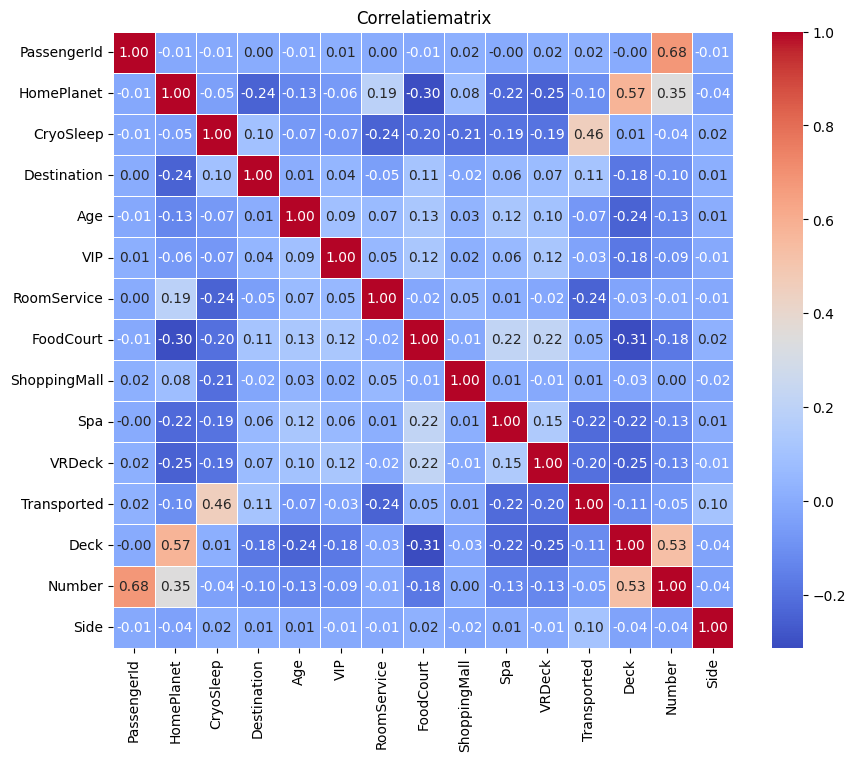

In [57]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlatiematrix')
plt.show()

* Zoals je ziet het ziet er allemaal redelijk blauw uit. dit betekent *weinig* correlatie tussen alle features. We hebben alle values toch al veranderd in numerieke waardes, dus we zullen geen features droppen.

## Test Data aanpassen

* We zullen voor de test data ongeveer dezelfde stappen doorlopen als met de train data om ze daarna te kunnen vergelijken.

In [58]:
url2 = 'test.csv'
test_df = pd.read_csv(url2)

In [59]:
test_df.fillna(method='pad', inplace=True)

In [60]:
test_df.drop('Name', axis=1, inplace=True)

In [61]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0


In [62]:
test_df[['Deck', 'Number', 'Side']] = test_df['Cabin'].str.split('/', expand=True)
test_df = test_df.drop('Cabin', axis=1)

In [63]:
test_df['CryoSleep'] = test_df['CryoSleep'].map({True: 1, False: 0})
test_df['VIP'] = test_df['VIP'].map({True: 1, False: 0})
test_df['Destination'] = test_df['Destination'].map({'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2})
test_df['Deck'] = test_df['Deck'].map({'B': 1, 'F': 5, 'A': 0, 'G': 6, 'E': 4, 'D': 3, 'C': 2, 'T': 7})
test_df['Side'] = test_df['Side'].map({'P': 0, 'S': 1})
test_df['HomePlanet'] = test_df['HomePlanet'].map({'Europa': 0, 'Earth': 1, 'Mars': 2})

In [64]:
test_df['Number'] = pd.to_numeric(test_df['Number'])

In [65]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Number,Side
0,0013_01,1,1,0,27.0,0,0.0,0.0,0.0,0.0,0.0,6,3,1
1,0018_01,1,0,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,5,4,1
2,0019_01,0,1,2,31.0,0,0.0,0.0,0.0,0.0,0.0,2,0,1
3,0021_01,0,0,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,2,1,1
4,0023_01,1,0,0,20.0,0,10.0,0.0,635.0,0.0,0.0,5,5,1


## Trainen

* Na alle preparatie kunnen we de data trainen op verschillende ml modellen.

In [66]:
X_train = df.drop('Transported', axis=1)
Y_train = df['Transported']
X_test = test_df
X_train.shape, Y_train.shape, X_test.shape

((8693, 14), (8693,), (4277, 14))

In [67]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

78.06

In [80]:
# k-nearest neighbours

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred_knn = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

81.35

In [69]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

66.66

In [70]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

52.4

In [71]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

/Users/jchm/ml/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/jchm/ml/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


50.22

In [72]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

52.01

In [73]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

100.0

In [74]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

100.0

In [75]:
models = pd.DataFrame({
    'Model': [ 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [ acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,100.00
7,Decision Tree,100.00
0,KNN,81.35
1,Logistic Regression,78.06
3,Naive Bayes,66.66
4,Perceptron,52.40
5,Stochastic Gradient Decent,52.01
6,Linear SVC,50.22


/var/folders/4x/0fyln44x5l52yj0tn794p3t80000gn/T/ipykernel_47109/2966454566.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Model', data=models.sort_values(by='Score', ascending=False), palette='viridis')


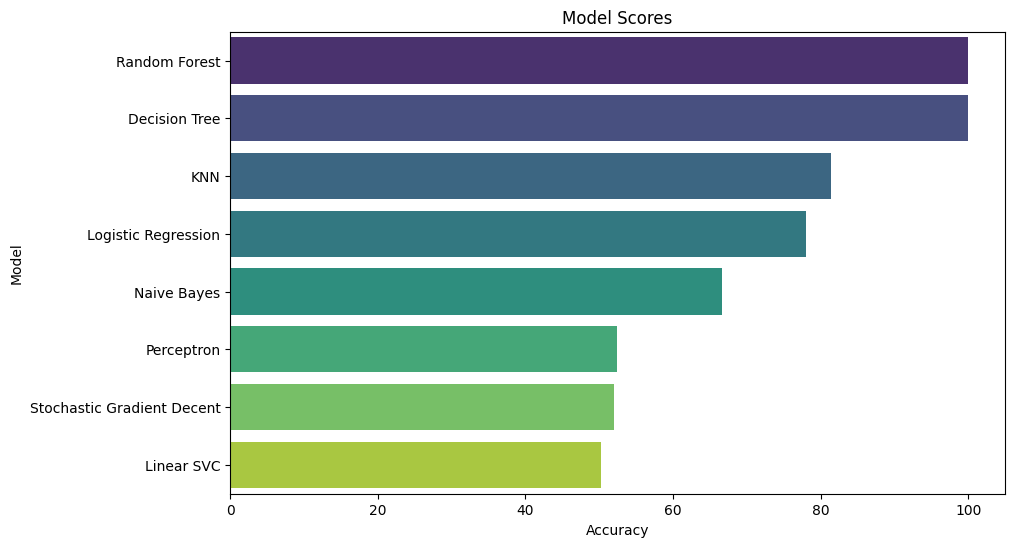

In [76]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Model', data=models.sort_values(by='Score', ascending=False), palette='viridis')
plt.title('Model Scores')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()

## Conclusies

* We zien dat Random Forest en Decision Tree 100% goed hadden. Dit is natuurlijk onmogelijk. Er is dus iets fout gegaan. De values zijn overfitted. Deze algoritmes zijn daarom niet goed voor ons.
* Vervolgens zien we 3 algoritmes die rond de 50% goed hebben, die hebben dit waarschijnlijk gewoon goed gegokt tussen True of False.
* We komen dan aan bij KNN en Logistic Regression die het goed hebben gedaan, rond de 80%.

* Ik ga verder door op KNN.
* We maken een confusion matrix.
* Ook een classificatie rapport.
* Roc curve

### Confusion matrix

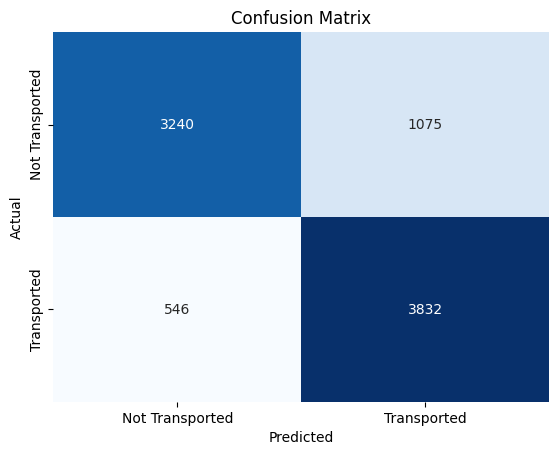

In [89]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_train, knn.predict(X_train))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Transported', 'Transported'],
            yticklabels=['Not Transported', 'Transported'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

* **True Positives (TP): 3832.** Dit zijn de passagiers die **wel** zijn getransporteerd en correct zijn voorspeld als getransporteerd.
* **True Negatives (TN): 3240.** Dit zijn de passagiers die **niet** zijn getransporteerd en correct zijn voorspeld als niet-getransporteerd.
* **False Positives (FP): 1075.** Dit zijn de passagiers die **niet** zijn getransporteerd maar zijn voorspeld als getransporteerd.
* **False Negatives (FN): 546.** Dit zijn de passagiers die **wel** zijn getransporteerd maar zijn voorspeld als niet-getransporteerd.

### Classification report

In [87]:
print(classification_report(Y_train, knn.predict(X_train)))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      4315
           1       0.78      0.88      0.83      4378

    accuracy                           0.81      8693
   macro avg       0.82      0.81      0.81      8693
weighted avg       0.82      0.81      0.81      8693



- **Precision:** Geeft aan hoeveel van de voorspelde positieve gevallen daadwerkelijk positief zijn. Voor klasse 0 is de precisie 0.86 en voor klasse 1 is de precisie 0.78. Hoge precisie betekent betrouwbare voorspellingen.

- **Recall:** Geeft aan hoeveel van de werkelijke positieve gevallen zijn opgepikt door het model. Voor klasse 0 is de recall 0.75 en voor klasse 1 is de recall 0.88. Hoge recall betekent dat het model de meeste positieve gevallen heeft geïdentificeerd.

- **F1-score:** Het harmonische gemiddelde van precisie en recall. Voor klasse 0 is de F1-score 0.80 en voor klasse 1 is de F1-score 0.83.

- **Accuracy:** De totale nauwkeurigheid is 0.81, wat betekent dat het model ongeveer 81% van alle voorbeelden correct heeft geclassificeerd.

### Roc curve

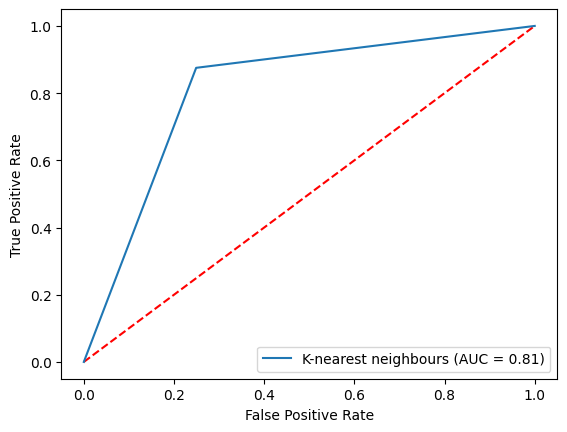

In [95]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fig,ax = plt.subplots()

plt.plot([0,1], [0,1], color='red', linestyle='--')

fpr, tpr, thresholds = roc_curve(Y_train, knn.predict(X_train))
roc_auc = auc(fpr, tpr)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='K-nearest neighbours')
disp.plot(ax=ax)

* Al met al de KNN model heeft een goeie performance met 81% goed berekend. Dat vind ik zelf wel een goeie resultaat als je kijkt naar de weinige correlatie tussen alle features.